In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## set parameter

In [2]:
train_test_ratio = 0.8

## load data

In [3]:
data=pd.read_csv("stock_data.csv")

In [4]:
data=data[::-1].reset_index(drop=True)

In [5]:
data

,Date,Open,High,Low,Close,Volume
0,2012/3/27,30.8,31.00,30.05,30.05,250.117
1,2012/3/28,30.1,30.10,29.55,29.70,253.665
2,2012/3/29,29.2,29.45,27.65,27.65,394.550
3,2012/3/30,27.1,28.80,26.90,28.50,230.055
4,2012/4/2,28.3,28.30,27.30,27.30,177.204
...,...,...,...,...,...,...
2447,2022/3/21,116.0,120.00,114.00,117.00,18370.022
2448,2022/3/22,115.5,118.00,114.00,117.50,7185.992
2449,2022/3/23,114.5,115.00,109.00,112.00,14177.186
2450,2022/3/24,111.0,121.00,110.50,121.00,15478.208


## preprocessing/F.E.

In [6]:
# data=data.set_index('Date')

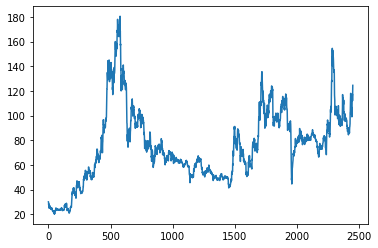

In [7]:
plt.plot(data['Close'])

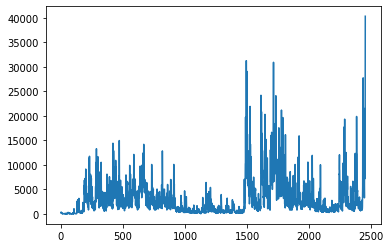

In [8]:
plt.plot(data['Volume'])

In [9]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
col=['Open', 'High', 'Low', 'Volume']
data[col] = scaler.fit_transform(data[col])

In [11]:
close_scaler=MinMaxScaler(feature_range=(0,1))
data['Close']=close_scaler.fit_transform(np.array(data['Close']).reshape(-1,1))

In [12]:
def create_dataset(data, time_step=100):
    X,Y = [],[]
    for i in range(len(data)-time_step-5+1):
        col=['Open','High','Low','Close','Volume']
        temp=data.iloc[i:(i+time_step)][col].values.tolist()
        X.append(temp)
        col='Close'
        temp=data.iloc[i + time_step:i + time_step+5][col].values.tolist()
        Y.append(temp)
    return np.array(X),np.array(Y)

In [13]:
train_data=data[:]

In [14]:
train_x, train_y = create_dataset(train_data)

In [15]:
print(train_x.shape, train_y.shape)

(2348, 100, 5) (2348, 5)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [17]:
model=Sequential()
n_neurons = train_x.shape[1] * train_x.shape[2]

model.add(LSTM(n_neurons,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(n_neurons,return_sequences=True))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 500)          1012000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 500)          2002000   
                                                                 
 lstm_2 (LSTM)               (None, 500)               2002000   
                                                                 
 dense (Dense)               (None, 100)               50100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0

In [19]:
epochs = 100
batch_size = 64
history = model.fit(train_x,
                    train_y, 
                    batch_size=batch_size, 
                    epochs=epochs,
                   )

Epoch 1/100
37/37 [==============================] - 11s 172ms/step - loss: 0.0669
Epoch 2/100
37/37 [==============================] - 6s 171ms/step - loss: 0.0414
Epoch 3/100
37/37 [==============================] - 6s 172ms/step - loss: 0.0283
Epoch 4/100
37/37 [==============================] - 6s 170ms/step - loss: 0.0216
Epoch 5/100
37/37 [==============================] - 6s 171ms/step - loss: 0.0171
Epoch 6/100
37/37 [==============================] - 6s 171ms/step - loss: 0.0152
Epoch 7/100
37/37 [==============================] - 6s 173ms/step - loss: 0.0131
Epoch 8/100
37/37 [==============================] - 6s 172ms/step - loss: 0.0113
Epoch 9/100
37/37 [==============================] - 6s 172ms/step - loss: 0.0097
Epoch 10/100
37/37 [==============================] - 6s 172ms/step - loss: 0.0090
Epoch 11/100
37/37 [==============================] - 6s 173ms/step - loss: 0.0086
Epoch 12/100
37/37 [==============================] - 6s 174ms/step - loss: 0.0082
Epoch 13/100

37/37 [==============================] - 7s 181ms/step - loss: 0.0036
Epoch 100/100
37/37 [==============================] - 7s 181ms/step - loss: 0.0036


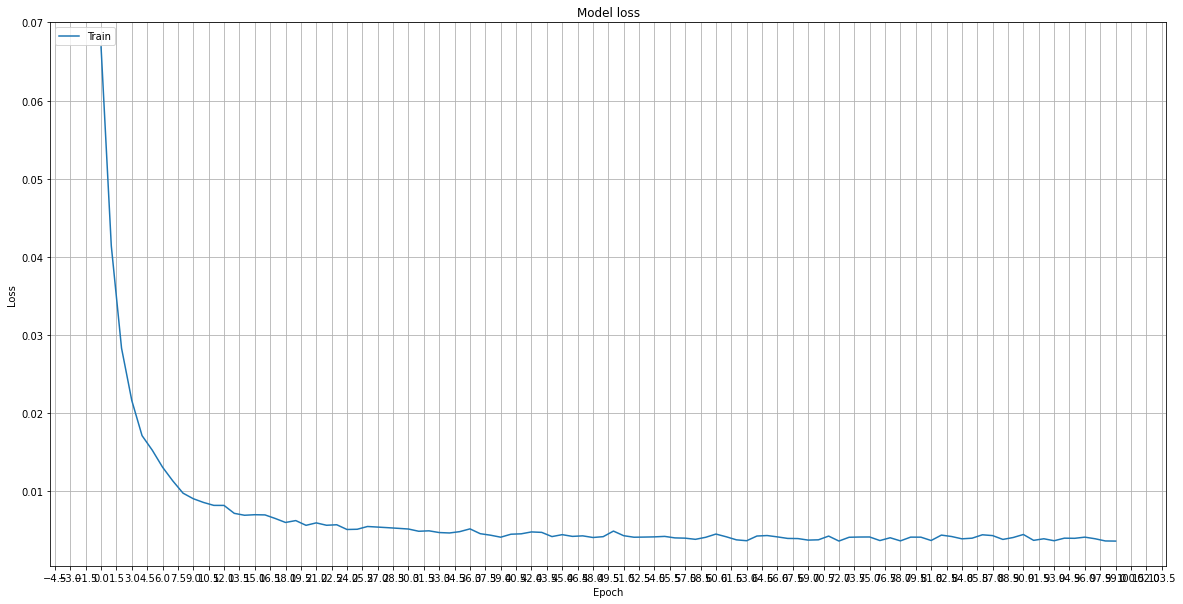

In [20]:
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

In [21]:
train_predict=model.predict(train_x)

In [22]:
math.sqrt(mean_squared_error(train_y,train_predict))

0.03663946214947102

In [23]:
train_predict=[close_scaler.inverse_transform(i.reshape(-1,1)) for i in train_predict]

In [24]:
def five2one(five):
    one = [[] for _ in range(len(five)+4)]
    for i in range(len(five)):
        for j in range(5):
            one[i+j].append(float(five[i][j]))
    return [sum(i)/len(i) for i in one]

In [25]:
single_train_predict = five2one(train_predict)

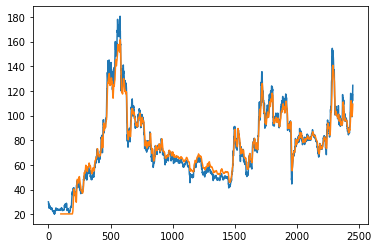

In [26]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(data['Close'])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(single_train_predict)+look_back] = single_train_predict
# plot baseline and predictions
plt.plot(close_scaler.inverse_transform(np.array(data['Close']).reshape(-1,1)))
plt.plot(trainPredictPlot)
plt.show()

In [27]:
newest=data[-100:][['Open','High','Low','Close','Volume']].values.tolist()

In [28]:
train_predict=model.predict([newest])

In [29]:
train_predict

array([[0.6135373 , 0.61252403, 0.61180985, 0.6106879 , 0.60865176]],
      dtype=float32)

In [30]:
close_scaler.inverse_transform(train_predict.reshape(-1,1))

array([[118.58868 ],
       [118.42635 ],
       [118.31194 ],
       [118.1322  ],
       [117.806015]], dtype=float32)